# 第五课 CNN图像分类

褚则伟 zeweichu@gmail.com

参考资料
- [Stanford CS231n](http://cs231n.github.io/convolutional-networks/)
- [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
- [VGG](https://arxiv.org/pdf/1409.1556.pdf)
- [ResNet](https://arxiv.org/pdf/1512.03385.pdf)
- [DenseNet](https://arxiv.org/pdf/1608.06993.pdf)



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.12.1+cu116


首先我们定义一个基于ConvNet的简单神经网络

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # 28 * 28 -> (28+1-5) 24 * 24
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # 20 * 20
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # x: 1 * 28 * 28
        x = F.relu(self.conv1(x)) # 20 * 24 * 24
        x = F.max_pool2d(x,2,2) # 20 * 12 * 12
        x = F.relu(self.conv2(x)) # 50 * 8 * 8
        x = F.max_pool2d(x,2,2) # 50 * 4 *4 
        x = x.view(-1, 4*4*50) # reshape (5 * 2 * 10), view(5, 20) -> (5 * 20)
        x = F.relu(self.fc1(x))  # 50 * 4 * 4 ---> 500
        x= self.fc2(x)
        # return x
        return F.log_softmax(x, dim=1) # log probability
        

In [23]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST("./mnist_data", train=True, download=True
                            , transform=transform
                           )
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [20]:
data = [d[0].data.cpu().numpy() for d in mnist_data]

In [22]:
np.mean(data)

0.13066062

In [23]:
np.std(data)

0.30810776

In [19]:
mnist_data[223][0].shape

torch.Size([1, 28, 28])

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        pred = model(data) # batch_size * 10
        loss = F.nll_loss(pred, target) 
        
        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print("Train Epoch: {}, iteration: {}, Loss: {}".format(
                epoch, idx, loss.item()))

In [7]:
def test(model, device, test_loader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data) # batch_size * 10
            total_loss += F.nll_loss(output, target, reduction="sum").item() 
            pred = output.argmax(dim=1) # batch_size * 1
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    total_loss /= len(test_loader.dataset)
    acc = correct/len(test_loader.dataset) * 100.
    print("Test loss: {}, Accuracy: {}".format(total_loss, acc))

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=True, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", train=False, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

lr = 0.01
momentum  = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    
torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 0, iteration: 0, Loss: 2.283817768096924
Train Epoch: 0, iteration: 100, Loss: 0.6110288500785828
Train Epoch: 0, iteration: 200, Loss: 0.18155980110168457
Train Epoch: 0, iteration: 300, Loss: 0.31043028831481934
Train Epoch: 0, iteration: 400, Loss: 0.518582284450531
Train Epoch: 0, iteration: 500, Loss: 0.1202855259180069
Train Epoch: 0, iteration: 600, Loss: 0.0989612340927124
Train Epoch: 0, iteration: 700, Loss: 0.09637182205915451
Train Epoch: 0, iteration: 800, Loss: 0.13470694422721863
Train Epoch: 0, iteration: 900, Loss: 0.06548292934894562
Train Epoch: 0, iteration: 1000, Loss: 0.03107370436191559
Train Epoch: 0, iteration: 1100, Loss: 0.03948028385639191
Train Epoch: 0, iteration: 1200, Loss: 0.09810394793748856
Train Epoch: 0, iteration: 1300, Loss: 0.15199752151966095
Train Epoch: 0, iteration: 1400, Loss: 0.016710489988327026
Train Epoch: 0, iteration: 1500, Loss: 0.005827277898788452
Train Epoch: 0, iteration: 1600, Loss: 0.0754864513874054
Train Epoch: 0,

NLL loss的定义

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_{y_n} x_{n,y_n}, \quad
        w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\}$

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST("./fashion_mnist_data", train=True, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST("./fashion_mnist_data", train=False, download=True,
           transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,))
           ])),
    batch_size=batch_size, shuffle=True, 
    num_workers=1, pin_memory=True
)

lr = 0.01
momentum  = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    
torch.save(model.state_dict(), "fashion_mnist_cnn.pt")

Train Epoch: 0, iteration: 0, Loss: 2.2878565788269043
Train Epoch: 0, iteration: 100, Loss: 1.04563570022583
Train Epoch: 0, iteration: 200, Loss: 0.6176483035087585
Train Epoch: 0, iteration: 300, Loss: 0.8869094848632812
Train Epoch: 0, iteration: 400, Loss: 0.4964980483055115
Train Epoch: 0, iteration: 500, Loss: 0.6115285158157349
Train Epoch: 0, iteration: 600, Loss: 0.5478923916816711
Train Epoch: 0, iteration: 700, Loss: 0.3371019959449768
Train Epoch: 0, iteration: 800, Loss: 0.799106240272522
Train Epoch: 0, iteration: 900, Loss: 0.3504491448402405
Train Epoch: 0, iteration: 1000, Loss: 0.7662918567657471
Train Epoch: 0, iteration: 1100, Loss: 0.6141698956489563
Train Epoch: 0, iteration: 1200, Loss: 0.6124005317687988
Train Epoch: 0, iteration: 1300, Loss: 0.7012341618537903
Train Epoch: 0, iteration: 1400, Loss: 0.4727810025215149
Train Epoch: 0, iteration: 1500, Loss: 0.2913166582584381
Train Epoch: 0, iteration: 1600, Loss: 0.1693815290927887
Train Epoch: 0, iteration: 17

# CNN模型的迁移学习

- 很多时候当我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用_预训练_的模型来加速训练的过程。我们经常使用在`ImageNet`上的预训练模型。
- 这是一种transfer learning的方法。我们常用以下两种方法做迁移学习。
    - fine tuning: 从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    - feature extraction: 我们不再改变预训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征做来完成我们的训练任务。
    
以下是构建和训练迁移学习模型的基本步骤：
- 初始化预训练模型
- 把最后一层的输出层改变成我们想要分的类别总数
- 定义一个optimizer来更新参数
- 模型训练

In [24]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.13.1+cu116


数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

In [25]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params

# fine tuning: 使用預訓練參數，但所有參數都會進行調整
# feature_extract: 使用預訓練參數，但只會調正最後一層全連接層的參數
feature_extract = True

input_size = 224

读入数据
---------

现在我们知道了模型输入的size，我们就可以把数据预处理成相应的格式。


In [26]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [27]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
img = next(iter(dataloaders_dict["val"]))[0]

In [13]:
img.shape

torch.Size([32, 3, 224, 224])

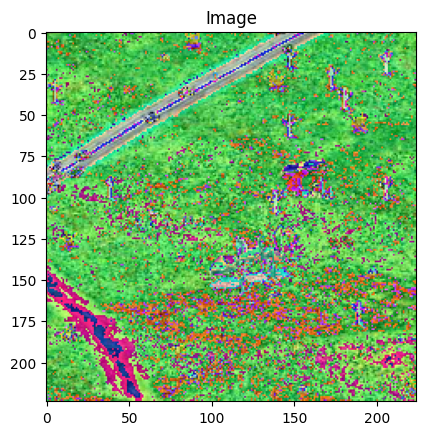

In [14]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[0], title='Image')


In [28]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        if use_pretrained:
            model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        else: 
            model_ft = models.resnet18()
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
        
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, 
                    num_classes, feature_extract, use_pretrained=True)
print(model_ft)
        
        

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [30]:
model_ft.fc.weight.requires_grad

True

In [37]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) 
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # 訓練效果好就更新
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)  # 從訓練效果最好的那次繼續訓練
    return model, val_acc_history

模型训练

In [32]:
model_ft = model_ft.to(device)

In [33]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_ft.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()


In [39]:
_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.4718437722471894, acc: 0.8360655737704918
Phase val loss: 0.4543033374680413, acc: 0.8300653594771242
Phase train loss: 0.45775382196316955, acc: 0.860655737704918
Phase val loss: 0.459424197868584, acc: 0.8300653594771242
Phase train loss: 0.45375905662286475, acc: 0.8319672131147541
Phase val loss: 0.4594819522371479, acc: 0.8235294117647058
Phase train loss: 0.45872200023932536, acc: 0.8483606557377049
Phase val loss: 0.4610110959585975, acc: 0.8169934640522876
Phase train loss: 0.4626567656876611, acc: 0.8483606557377049
Phase val loss: 0.46462901608616697, acc: 0.8104575163398693
Phase train loss: 0.4588236075932862, acc: 0.8483606557377049
Phase val loss: 0.46633456540263557, acc: 0.8300653594771242
Phase train loss: 0.4764019807831186, acc: 0.8114754098360656
Phase val loss: 0.4637915340124392, acc: 0.8169934640522876
Phase train loss: 0.45869110402513724, acc: 0.8442622950819673
Phase val loss: 0.46222292402990506, acc: 0.8104575163398693
Phase train loss: 0

In [38]:
model_scratch, _ = initialize_model(model_name, 
                    num_classes, feature_extract=False, use_pretrained=False)  
model_scratch = model_scratch.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_scratch.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
_, scratch_hist = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.6976348445063731, acc: 0.5081967213114754
Phase val loss: 0.6971713962897755, acc: 0.477124183006536
Phase train loss: 0.6716253933359365, acc: 0.5655737704918032
Phase val loss: 0.6555317059841032, acc: 0.6535947712418301
Phase train loss: 0.6596567796879127, acc: 0.5942622950819673
Phase val loss: 0.6566331437210632, acc: 0.6209150326797386
Phase train loss: 0.6161147795739721, acc: 0.6434426229508197
Phase val loss: 0.6249737844747656, acc: 0.6470588235294118
Phase train loss: 0.6077720884416924, acc: 0.6598360655737705
Phase val loss: 0.6333262655470107, acc: 0.673202614379085
Phase train loss: 0.5588163909364919, acc: 0.7295081967213115
Phase val loss: 0.6122387896955402, acc: 0.6862745098039216
Phase train loss: 0.5782819214414378, acc: 0.680327868852459
Phase val loss: 0.6050593260846107, acc: 0.6862745098039216
Phase train loss: 0.5407538326060186, acc: 0.7172131147540983
Phase val loss: 0.5921609779588537, acc: 0.7058823529411765
Phase train loss: 0.5569934

我们来plot模型训练时候loss的变化

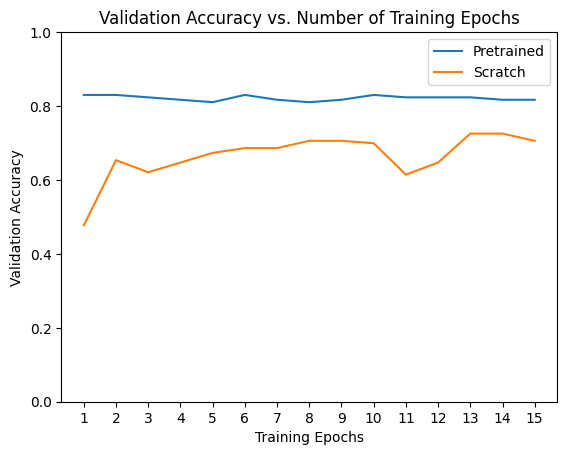

In [40]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# 使用pretrain和沒使用pretrain的模型進行比較
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### 课后学习

- [BERT](https://github.com/huggingface/pytorch-pretrained-BERT)
- [ElMo](https://github.com/allenai/allennlp/blob/master/allennlp/modules/elmo.py)
- [Torch Vision Models](https://github.com/pytorch/vision/tree/master/torchvision/models)